# Covid-19 Time Series Forecasting

In this notebook, I try to forecast time series of covid-19 using Recurrent Neural Networks (RNNs). Let's start with installing dependencies.

In [ ]:
pip install -r requirements.txt

Import dependecies.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Define dataset url.

In [2]:
URL = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

Download dataset.

In [3]:
home = os.path.expanduser("~")
dataset_path = os.path.join(home, '.keras/datasets/dataset.csv')

if os.path.exists(dataset_path):
    os.remove(dataset_path)
else:
    print('Dataset does not exist')

dataset_path = tf.keras.utils.get_file(
        origin=URL,
        fname='dataset.csv')

835584/829325 [==============================] - 1s 1us/step


Start reading dataset and display a few lines of each to get an idea.

In [4]:
df = pd.read_csv(dataset_path)
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
1,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia
2,29/04/2020,29,4,2020,124,3,Afghanistan,AF,AFG,37172386.0,Asia
3,28/04/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
4,27/04/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia


The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

Get number of rows of available with country name from data frame.

In [6]:
number_of_rows = len(df)
number_of_rows

14242

In [7]:
TRAIN_SPLIT = int((number_of_rows * 60) / 100)
TRAIN_SPLIT

8545

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

We will train a model using only number of cases, and use it to make predictions for that value in the future.

In [9]:
uni_data = df['cases']
uni_data.index = df['dateRep']
uni_data.head()

dateRep
01/05/2020    222
30/04/2020    122
29/04/2020    124
28/04/2020    172
27/04/2020     68
Name: cases, dtype: int64

Draw a graph of dataframe to see how it looks like.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ec098d0>],
      dtype=object)

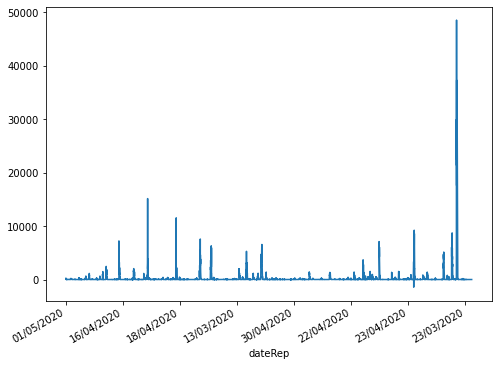

In [10]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

Scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardize the data.

In [13]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [15]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target cases to predict')
print(y_train_uni[0])

Single window of past history
[[ 0.14293961]
 [-0.02423424]
 [-0.02089076]
 [ 0.05935268]
 [-0.11450812]
 [-0.04095163]
 [-0.11116464]
 [-0.0526538 ]
 [-0.0877603 ]
 [-0.12621029]
 [-0.16967549]
 [-0.08107335]
 [-0.12286681]
 [-0.14292767]
 [-0.21146895]
 [-0.11116464]
 [-0.14627115]
 [-0.1312255 ]
 [-0.14125594]
 [-0.17134723]]

 Target cases to predict
-0.16633201252591354


In [16]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

The information given to the network is given in blue, and it must predict the value at the red cross.

<module 'matplotlib.pyplot' from '/Users/abdullahselek/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

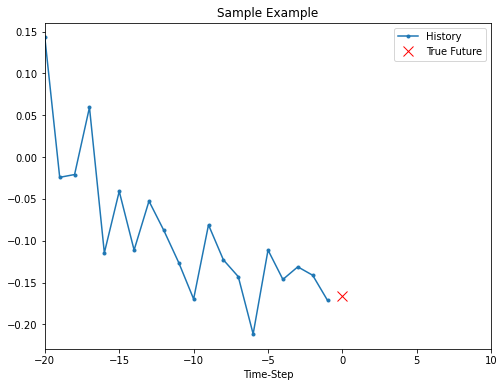

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

<module 'matplotlib.pyplot' from '/Users/abdullahselek/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

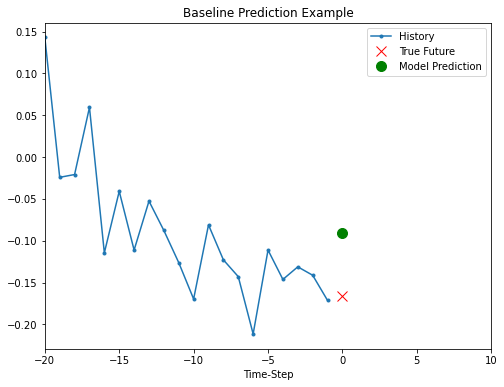

In [18]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

I am going to create a Recurrent Neural Network (RNN), which is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Sample prediction, to check the output of the model.

In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Train the model now. Due to the small size of the dataset each epoch will only run for 300 steps.

In [22]:
EVALUATION_INTERVAL = 300
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=75)

Train for 300 steps, validate for 75 steps
Epoch 1/10
300/300 [==============================] - 4s 12ms/step - loss: 0.1715 - val_loss: 0.4308
Epoch 2/10
300/300 [==============================] - 2s 8ms/step - loss: 0.1189 - val_loss: 0.3906
Epoch 3/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0996 - val_loss: 0.3711
Epoch 4/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0897 - val_loss: 0.3583
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0840 - val_loss: 0.3487
Epoch 6/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0818 - val_loss: 0.3413
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0789 - val_loss: 0.3352
Epoch 8/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0768 - val_loss: 0.3304
Epoch 9/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0759 - val_loss: 0.3252
Epoch 10/10
300/300 [==============================] - 2

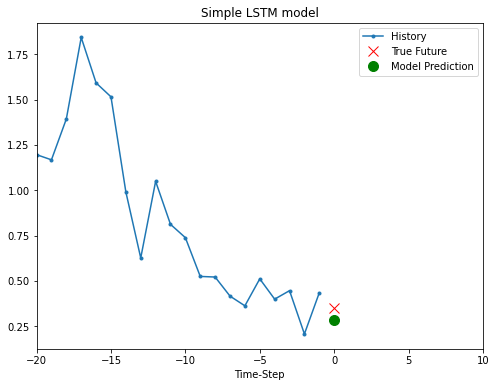

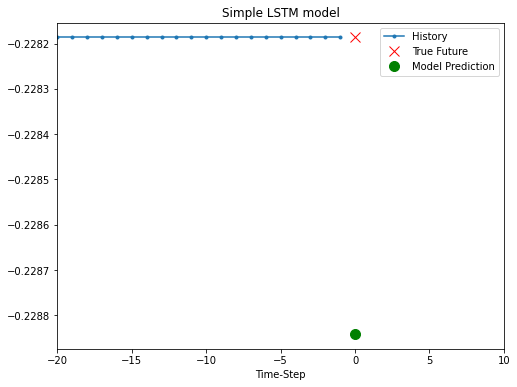

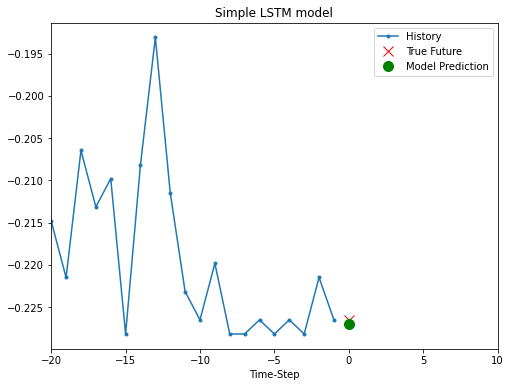

In [23]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()